# Double Q-Learning

This notebook shows the tabular reinforcement learning algorithm, Double Q-Learning applied to the Taxi problem (it also works on CliffWalking and FrozenLake) from Open AI's gym. Double Q-Learning is an off-policy Temporal Difference control algorithm. Two action value functions, $Q_1$ and $Q_2$ are used for this method, which are both used for estimating the discounted return and selecting the optimal action, hence the name double learning. This algorithm improves on the standard Q-Learning algorithm by reducing the impact of maximization bias. Maximimization bias can occur when there is uncertainty in the return of the actions in a given state. For example if the return of all the actions in a state is 0, but the estimated returns are non-zero, (some positive and others negative), then the maximum of the values will be positive. This results in a positive bias, which we call a maximization bias.  

The action $A$ is selected by using the $\epsilon$-greedy policy on $(Q_1 + Q_2) / 2$, then with 50% probability the following update is performed:
$$Q_1(S_t, A_t) \leftarrow Q_1(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q_2(S_{t + 1}, \argmax_{a}Q_1(S_{t + 1}, a)) - Q_1(S_t, A_t)]$$
, otherwise the following update is performed:
$$Q_2(S_t, A_t) \leftarrow Q_2(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q_1(S_{t + 1}, \argmax_{a}Q_2(S_{t + 1}, a)) - Q_2(S_t, A_t)]$$
, where $Q1$ and $Q2$ are the learned action-value functions, $R$ is the reward, $A$ is the action, $\alpha$ is the step size, $\gamma$ is the discount rate and $t$ is the time step.

The learned action-value functions $Q1$ and $Q2$ directly approximates the optimal action-value function $q_*$ independent of the policy being followed. For more information on Double Q-Learning see section 6.7 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf).

In [21]:
import gym
import numpy as np
import random

In [22]:
# Type of environment, options include:
# Taxi-v3, CliffWalking-v0, FrozenLake-v1
env_type = "Taxi-v3"
# Create the environment
env = gym.make(env_type, render_mode=None)

# Number of possible states and actions
num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
Q1 = np.zeros([num_states, num_actions])
Q2 = np.zeros([num_states, num_actions])

## Create An $\epsilon$-Greedy Policy 

In [23]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Find the best action
    best_action = np.argmax(Q[state, :])
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [24]:
# Number of episodes to train on
episodes = 500
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Step size
alpha = 0.618
# Probability of taking a non-greedy action
epsilon = 0.01

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    while not terminated:
        # Select the action following the epsilon-greedy policy
        action_dist1 = policy_fn(state, Q1, epsilon, num_actions)
        action_dist2 = policy_fn(state, Q2, epsilon, num_actions)
        action_dist = (action_dist1 + action_dist2) / 2
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        # Randomly update action value function Q1 or Q2
        rand_value = random.uniform(0, 1)
        if rand_value > 0.5:
            # Update the expected return for the action-value function Q1
            Q1[state, action] += alpha * (reward + gamma * Q2[next_state, np.argmax(Q1[next_state, :])] - Q1[state, action]) 
        else:
            # Update the expected return for the action-value function Q2
            Q2[state, action] += alpha * (reward + gamma * Q1[next_state, np.argmax(Q2[next_state, :])] - Q2[state, action]) 
        G += reward
        state = next_state

    returns.append(G)

    if episode % 10 == 0:
        print(f'Episode: {episode} Return: {G}')

Episode: 10 Return: -3964
Episode: 20 Return: -10
Episode: 30 Return: -822
Episode: 40 Return: -657
Episode: 50 Return: -331
Episode: 60 Return: -651
Episode: 70 Return: -31
Episode: 80 Return: -21
Episode: 90 Return: -1
Episode: 100 Return: -25
Episode: 110 Return: -159
Episode: 120 Return: -62
Episode: 130 Return: -10
Episode: 140 Return: -80
Episode: 150 Return: -56
Episode: 160 Return: -162
Episode: 170 Return: 5
Episode: 180 Return: -161
Episode: 190 Return: -28
Episode: 200 Return: -41
Episode: 210 Return: 8
Episode: 220 Return: 3
Episode: 230 Return: -58
Episode: 240 Return: 0
Episode: 250 Return: -9
Episode: 260 Return: 10
Episode: 270 Return: -52
Episode: 280 Return: -56
Episode: 290 Return: -7
Episode: 300 Return: -5
Episode: 310 Return: 15
Episode: 320 Return: 4
Episode: 330 Return: -84
Episode: 340 Return: 3
Episode: 350 Return: -12
Episode: 360 Return: 5
Episode: 370 Return: 10
Episode: 380 Return: -9
Episode: 390 Return: -9
Episode: 400 Return: 11
Episode: 410 Return: 2
E

## Plot The Results

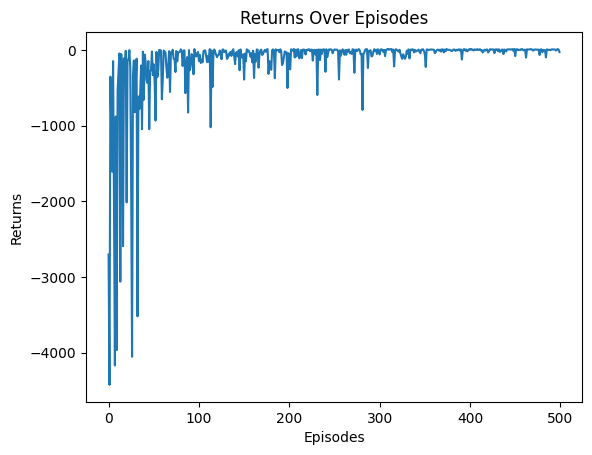

In [25]:
import matplotlib.pyplot as plt

plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Run $q*$ On An Example

In [26]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(env_type, render_mode="human")
state, info = env.reset(seed=48)
G = 0
num_steps = 0
terminated = False

while not terminated:
    action = np.argmax(Q[state, :]) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: 5, Steps Taken: 16
